# Data-driven modelling for on-demand flow prescription in fan-array wind tunnels
Alejandro Stefan-Zavala [1], Isabel Scherl, Ioannis Mandralis, Steven L. Brunton and Morteza Gharib

[1] Corresponding author: aastefan@caltech.edu

# Code supplement
Publication DOI: https://doi.org/10.1017/flo.2025.10034


---
# Dataset Overview

In [1]:
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_formats = ['svg'] # vectorized plots in notebook

### Load dataset

In [2]:
fname = 'dataset.pickle'
with open(fname, 'rb') as f:
    D = pk.load(f)

# Summarize keys
todo = [tuple(), ('data',), ('common',), ('data', '1'),]
for keys in todo:
    d = D
    for key in keys:
        d = d[key]
    print('- D' + ''.join([f'[\'{key}\']' for key in keys]) + \
          ' keys:\n  ', ', '.join([f"'{k}'" for k in d.keys()]))

- D keys:
   'notes_internal', 'README', 'keys_explained', 'data', 'common'
- D['data'] keys:
   '1', '1/2', '1/4', '1/8'
- D['common'] keys:
   'xLs_str', 'R_train', 'R_test', 'N_train', 'N_test', 'N_fans', 'N_sensors', 'L', 'd', 'V_max', 'yLs', 'yLs_edges', 'yLs_hubs'
- D['data']['1'] keys:
   'xL', 'V_train', 'V_train_std', 'V_test', 'V_test_std', 'A', 'b', 'N_iv', 'V_target_iv', 'R_iv', 'V_pred_iv', 'V_measured_iv', 'V_measured_iv_std'


---

# Helper functions

In [3]:
def plotm(M, name, cmap, cbar='horizontal', aspect='auto', fig=None):
    fig = plt.figure() if fig is None else fig

    plt.imshow(M, cmap=cmap)
    if cbar is not None:
        plt.colorbar(orientation=cbar)
    plt.gca().set_aspect(aspect)
    plt.title(name)

    return fig

def plotdset(D, name='dataset', cmap='viridis', fig=None):
    return plotm(D, name=name, cmap=cmap, aspect='equal',fig=None)

---

## $x/L=1$ dataset

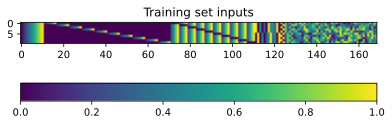

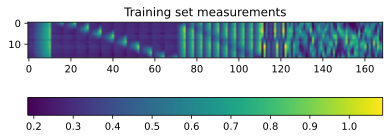

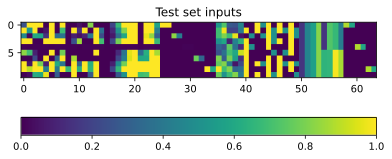

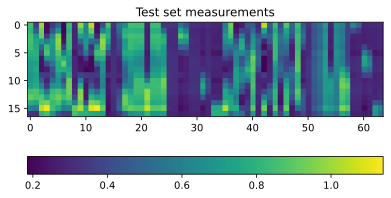

In [4]:
d = D['data']['1']
R_train = D['common']['R_train']
R_test = D['common']['R_test']
V_train = d['V_train']
V_test = d['V_test']

N_fans = D['common']['N_fans']
N_sensors = D['common']['N_sensors']
V_max = D['common']['V_max']

yLs_hubs = D['common']['yLs_hubs']
yLs = D['common']['yLs']

plotdset(R_train, "Training set inputs")
plotdset(V_train, "Training set measurements")
plotdset(R_test, "Test set inputs")
plotdset(V_test, "Test set measurements")

None

---

# Model fitting and execution

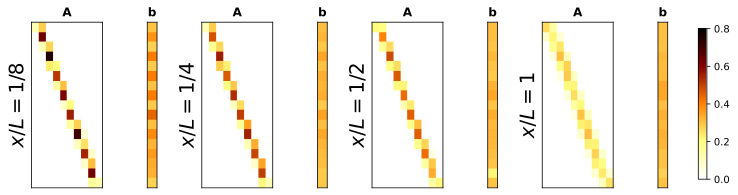

In [5]:
from sklearn.linear_model import Lasso

xLs_str = list(reversed(D['common']['xLs_str']))
nc = 2*len(xLs_str)
nr = 1
kp = 1
fig, axes = plt.subplots(nr, nc, figsize=(12, 3), sharey=True)
for xL in xLs_str:
    LS = Lasso(alpha=0.01)
    V_train = D['data'][xL]['V_train']
    LS.fit(R_train.T, V_train.T)
    A = LS.coef_
    b = LS.intercept_
    
    plt.subplot(nr, nc, kp); kp += 1
    plt.imshow(A, clim=(0,0.8), cmap='afmhot_r')
    plt.ylabel(f"$x/L={xL}$", fontsize=20)
    plt.title("$\\mathbf{A}$")
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect("auto")

    plt.subplot(nr, nc, kp); kp += 1
    im = plt.imshow(b[:,np.newaxis], clim=(0,0.8), cmap='afmhot_r')
    plt.xticks([])
    plt.yticks([])
    plt.title("$\\mathbf{b}$")
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
    

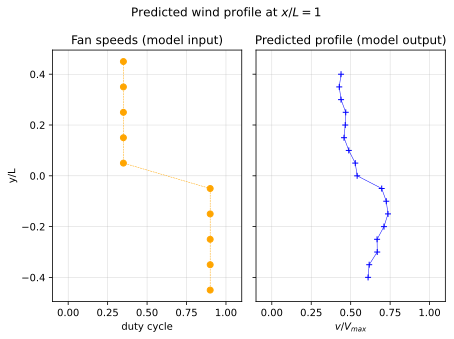

In [27]:
dc_high = 0.90
dc_low = 0.35
r = dc_high*np.ones((N_fans,))
r[:N_fans//2] = dc_low

v_pred = A@r + b

plt.subplots(1,2, sharey='row',)
plt.subplot(121)
plt.plot(r, yLs_hubs, marker='o', lw=0.5, ls='--', color='orange')
plt.grid(lw=0.5, ls='-', alpha=0.5)
plt.ylabel("y/L")
plt.xlabel('duty cycle')
plt.xlim([-0.1, 1.1])
plt.title('Fan speeds (model input)')
plt.subplot(122)
plt.plot(v_pred, yLs, marker='+', lw=0.5, ls='-', color='blue')
plt.grid(lw=0.5, ls='-', alpha=0.5)
plt.xlim([-0.1, 1.1])
plt.xlabel('$v/V_{max}$')
plt.title('Predicted profile (model output)')
plt.suptitle(f"Predicted wind profile at $x/L={xL}$")
plt.tight_layout()

---

# Inverse Design

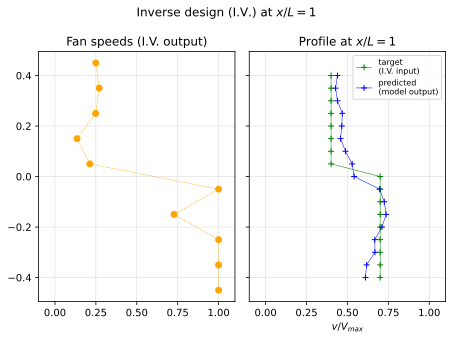

In [31]:
from scipy.optimize import least_squares

v_star = 0.7*np.ones((N_sensors,))
v_star[:N_sensors//2] = 0.4

f = lambda r:(A@r+b)-v_star
lb = np.zeros((N_fans,))
hb = np.ones((N_fans,))
r0 = np.random.rand(N_fans)
result = least_squares(f, r0, bounds=(lb,hb), loss='soft_l1')
r_hat = result.x

v_pred = A@r+b

plt.subplots(1,2, sharey='row')
plt.subplot(121)
plt.grid(lw=0.5, ls='-', alpha=0.5)
plt.plot(r_hat, yLs_hubs, marker='o', lw=0.5, ls='--', color='orange')
plt.xlim([-0.1, 1.1])
plt.title('Fan speeds (I.V. output)')
plt.subplot(122)
plt.grid(lw=0.5, ls='-', alpha=0.5)
plt.plot(v_star, yLs, marker='+', lw=0.5, ls='-', color='green',
         label='target\n(I.V. input)')
plt.plot(v_pred, yLs, marker='+', lw=0.5, ls='-', color='blue',
         label='predicted\n(model output)')
plt.xlim([-0.1, 1.1])
plt.xlabel("$v/V_{max}$")
plt.legend(fontsize=8)
plt.title(f'Profile at $x/L={xL}$')
plt.suptitle(f"Inverse design (I.V.) at $x/L={xL}$")
plt.tight_layout()